# Sequentially adding new points to a kriging

In this example, we show how to sequentially add new points to a kriging in order to improve the predictivity of the metamodel. In order to create simple graphics, we consider a 1D function. 

## Create the function and the design of experiments

In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np

In [2]:
sampleSize = 4
dimension = 1

Define the function.

In [3]:
g = ot.SymbolicFunction(['x'], ['0.5*x^2 + sin(2.5*x)'])

Create the design of experiments. 

In [4]:
xMin = -0.9
xMax = 1.9
X_distr = ot.Uniform(xMin, xMax)
X = ot.LHSExperiment(X_distr, sampleSize, False, False).generate()
Y = g(X)

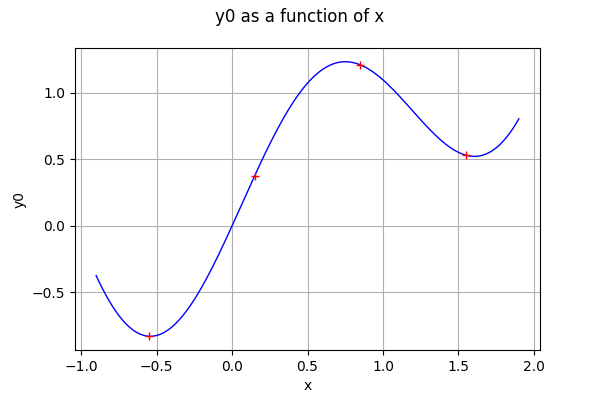

In [5]:
graph = g.draw(xMin, xMax)
data = ot.Cloud(X,Y)
data.setColor("red")
graph.add(data)
graph

## Create the algorithms

In [6]:
def createMyBasicKriging(X,Y):
    '''
    Create a kriging from a pair of X and Y samples.
    We use a 3/2 Matérn covariance model and a constant trend.
    '''
    basis = ot.ConstantBasisFactory(dimension).build()
    covarianceModel = ot.MaternModel([1.0], 1.5)    
    algo = ot.KrigingAlgorithm(X, Y, covarianceModel, basis)
    algo.run()
    krigResult = algo.getResult()
    return krigResult

In [7]:
def linearSample(xmin,xmax,npoints):
    '''Returns a sample created from a regular grid 
    from xmin to xmax with npoints points.'''
    step = (xmax-xmin)/(npoints-1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

In [8]:
def plot_kriging_bounds(vLow,vUp,n_test):
    '''
    From two lists containing the lower and upper bounds of the region, 
    create a PolygonArray.
    '''
    palette = ot.Drawable.BuildDefaultPalette(2)
    myPaletteColor = palette[1]
    polyData = [[vLow[i], vLow[i+1], vUp[i+1], vUp[i]] for i in range(n_test-1)]
    polygonList = [ot.Polygon(polyData[i], myPaletteColor, myPaletteColor) for i in range(n_test-1)]
    boundsPoly = ot.PolygonArray(polygonList)
    boundsPoly.setLegend("95% bounds")
    return boundsPoly

The following `sqrt` function will be used later to compute the standard deviation from the variance.

In [9]:
sqrt = ot.SymbolicFunction(["x"],["sqrt(x)"])

In [10]:
def plotMyBasicKriging(krigResult, xMin, xMax, X, Y, level = 0.95):
    '''
    Given a kriging result, plot the data, the kriging metamodel 
    and a confidence interval.
    '''
    samplesize = X.getSize()
    meta = krigResult.getMetaModel()
    graphKriging = meta.draw(xMin, xMax)
    graphKriging.setLegends(["Kriging"])
    # Create a grid of points and evaluate the function and the kriging
    nbpoints = 50
    xGrid = linearSample(xMin,xMax,nbpoints)
    yFunction = g(xGrid)
    yKrig = meta(xGrid)
    # Compute the conditional covariance
    epsilon = ot.Point(nbpoints,1.e-8)
    conditionalVariance = krigResult.getConditionalMarginalVariance(xGrid)+epsilon
    conditionalVarianceSample = ot.Sample(conditionalVariance,1)
    conditionalSigma = sqrt(conditionalVarianceSample)
    # Compute the quantile of the Normal distribution
    alpha = 1-(1-level)/2
    quantileAlpha = ot.DistFunc.qNormal(alpha)
    # Graphics of the bounds
    epsilon = 1.e-8
    dataLower = [yKrig[i,0] - quantileAlpha * conditionalSigma[i,0] for i in range(nbpoints)]
    dataUpper = [yKrig[i,0] + quantileAlpha * conditionalSigma[i,0] for i in range(nbpoints)]
    # Coordinates of the vertices of the Polygons
    vLow = [[xGrid[i,0],dataLower[i]] for i in range(nbpoints)] 
    vUp = [[xGrid[i,0],dataUpper[i]] for i in range(nbpoints)]
    # Compute the Polygon graphics
    boundsPoly = plot_kriging_bounds(vLow,vUp,nbpoints)
    boundsPoly.setLegend("95% bounds")
    # Validate the kriging metamodel
    mmv = ot.MetaModelValidation(xGrid, yFunction, meta)
    Q2 = mmv.computePredictivityFactor()
    # Plot the function
    graphFonction = ot.Curve(xGrid,yFunction)
    graphFonction.setLineStyle("dashed")
    graphFonction.setColor("magenta")
    graphFonction.setLineWidth(2)
    graphFonction.setLegend("Function")
    # Draw the X and Y observed
    cloudDOE = ot.Cloud(X, Y)
    cloudDOE.setPointStyle("circle")
    cloudDOE.setColor("red")
    cloudDOE.setLegend("Data")
    # Assemble the graphics
    graph = ot.Graph()
    graph.add(boundsPoly)
    graph.add(graphFonction)
    graph.add(cloudDOE)
    graph.add(graphKriging)
    graph.setLegendPosition("bottomright")
    graph.setAxes(True)
    graph.setGrid(True)
    graph.setTitle("Size = %d, Q2=%.2f%%" % (samplesize,100*Q2))
    graph.setXTitle("X")
    graph.setYTitle("Y")
    return graph

We start by creating the initial kriging metamodel on the 4 points in the design of experiments.

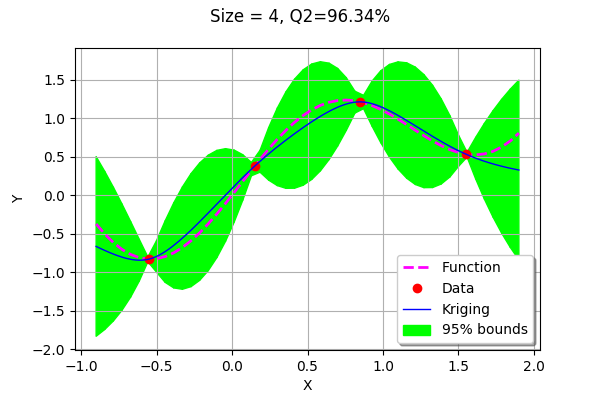

In [11]:
krigResult = createMyBasicKriging(X,Y)
plotMyBasicKriging(krigResult,xMin,xMax, X, Y)

## Sequentially add new points

The following function is the building block of the algorithm. It returns a new point which maximizes the conditional variance. 

In [12]:
def getNewPoint(xMin, xMax,krigResult):
    '''
    Returns a new point to be added to the design of experiments. 
    This point maximizes the conditional variance of the kriging. 
    '''
    nbpoints = 50
    xGrid = linearSample(xMin,xMax,nbpoints)
    conditionalVariance = krigResult.getConditionalMarginalVariance(xGrid)
    iMaxVar = int(np.argmax(conditionalVariance))
    xNew = xGrid[iMaxVar,0]
    xNew = ot.Point([xNew])
    return xNew

In [13]:
krigingStep = 0

We first call `getNewPoint` to get a point to add to the design of experiments.

In [14]:
xNew = getNewPoint(xMin, xMax,krigResult)
xNew

class=Point name=Unnamed dimension=1 values=[1.9]

Then we evaluate the function on the new point and add it to the training design of experiments.

In [18]:
yNew = g(xNew)
X.add(xNew)
Y.add(yNew)

We now plot the updated kriging.

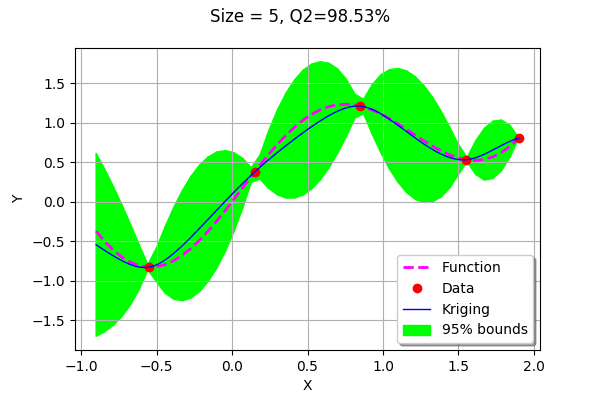

In [16]:
krigResult = createMyBasicKriging(X,Y)
krigingStep += 1
myTitle = "Krigeage #%d" % (krigingStep+1)
plotMyBasicKriging(krigResult,xMin,xMax, X, Y)

The algorithm added a point to the right bound of the domain.

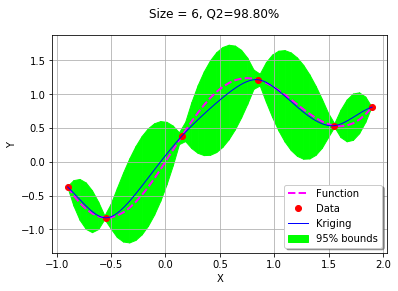

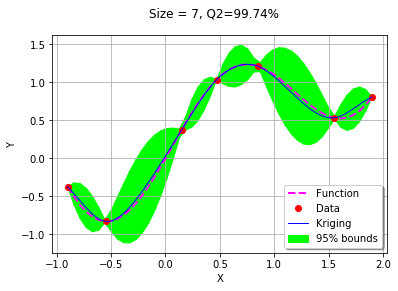

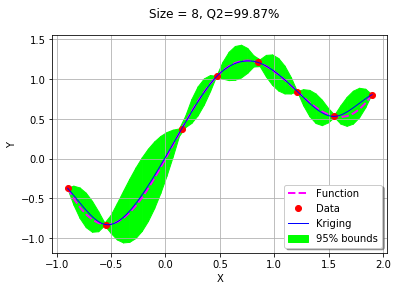

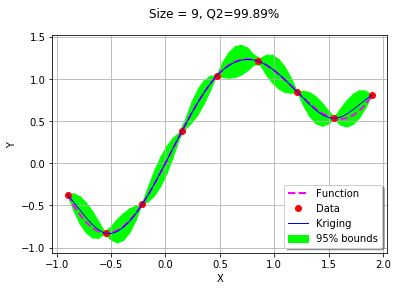

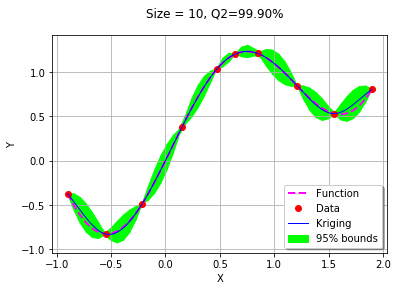

In [17]:
for krigingStep in range(5):
    xNew = getNewPoint(xMin, xMax,krigResult)
    yNew = g(xNew)
    X.add(xNew)
    Y.add(yNew)
    krigResult = createMyBasicKriging(X,Y)
    krigingStep += 1
    myTitle = "Krigeage #%d" % (krigingStep+1)
    graph = plotMyBasicKriging(krigResult,xMin,xMax, X, Y)
    View(graph)

We observe that the second added point is the left bound of the domain. The remaining points were added stricly inside the domain where the accuracy was drastically improved. 

With only 10 points, the metamodel accuracy is already very good with a Q2 which is equal to 99.9%. 

## Conclusion

The current example presents the naive implementation on the creation of a sequential design of experiments based on kriging. More pratical algorithms are presented in the following references.
* Mona Abtini. Plans prédictifs à taille fixe et séquentiels pour le krigeage (2008). Thèse de doctorat de l'Université de Lyon.
* Céline Scheidt. Analyse statistique d’expériences simulées : Modélisation adaptative de réponses non régulières par krigeage et plans d’expériences (2007). Thèse présentée pour obtenir le grade de Docteur de l’Université Louis Pasteur. 
* David Ginsbourger. Sequential Design of Computer Experiments. Wiley StatsRef: Statistics Reference Online, Wiley (2018 )